## Agent 구축

### 1. Model 및 Tool 정의

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
)

### 2.State

In [3]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    email_content : str
    category : str
    next_step : str
    response : str

### 3. Node

In [4]:
def read_email(state: AgentState):
    return {'email_content' : state['email_content']}

In [5]:
def classify_intent(state: AgentState):
    email = state['email_content']

    if '환불' in email or '긴급' in email or '빨리' in email :
        category = 'complaint'
        next_step = 'escalate_to_human'
    else :
        category = 'inquiry'
        next_step = 'search_manual'
        
    return {'category': category, 'next_step' : next_step}

In [18]:
def search_manual(state: AgentState):
    print('3-A 진입.. 메뉴얼을 검색합니다.')
    return

def escalate_to_human(state: AgentState):
    print('3-B 진입... 상담원 이관합니다.')
    return {'response' : '불편을 드려 죄송합니다.. 상담원에게 이관하였으니 잠시 대기해 주시기 바랍니다.'}

In [19]:
def write_reply(state: AgentState):
    email = state['email_content']
    response = model.invoke(email)
    return {'response': response}

### 4.그래프 생성

In [20]:
from langgraph.graph import StateGraph, START, END

agent_builder = StateGraph(AgentState)

agent_builder.add_node('read_email', read_email)
agent_builder.add_node('classify_intent', classify_intent)
agent_builder.add_node('search_manual', search_manual)
agent_builder.add_node('escalate_to_human', escalate_to_human)
agent_builder.add_node('write_reply', write_reply)

agent_builder.add_edge(START,'read_email')
agent_builder.add_edge('read_email','classify_intent')

In [21]:
def route_email(state: AgentState):
    if state['next_step'] == 'escalate_to_human' :
        return 'escalate_to_human'
    else :
        return 'search_manual'

In [22]:
agent_builder.add_conditional_edges(
    'classify_intent',
    route_email,
    ['escalate_to_human', 'search_manual']
)

In [23]:
agent_builder.add_edge('search_manual', 'write_reply')
agent_builder.add_edge('write_reply', END)
agent_builder.add_edge('escalate_to_human', END)

In [24]:
agent = agent_builder.compile()

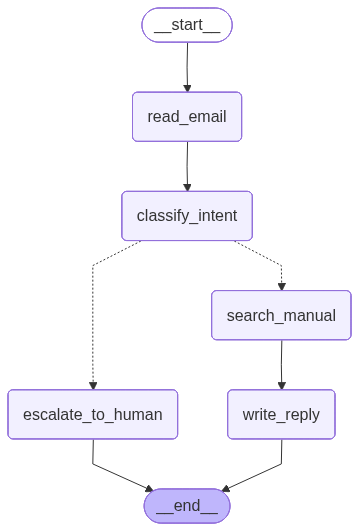

In [25]:
agent

In [27]:
inputs = {"email_content": "비밀번호 변경 방법을 알려주세요."}
response = agent.invoke(inputs)

3-A 진입.. 메뉴얼을 검색합니다.


In [28]:
response

{'email_content': '비밀번호 변경 방법을 알려주세요.',
 'category': 'inquiry',
 'next_step': 'search_manual'}

In [26]:
inputs ={"email_content": "당장 환불해줘!"}
response = agent.invoke(inputs)

3-B 진입... 상담원 이관합니다.


In [27]:
response

{'email_content': '당장 환불해줘!',
 'category': 'complaint',
 'next_step': 'escalate_to_human',
 'response': '불편을 드려 죄송합니다.. 상담원에게 이관하였으니 잠시 대기해 주시기 바랍니다.'}

In [15]:
inputs = {"email_content": "당장 환급해줘"}
response = agent.invoke(inputs)

3-A 진입.. 메뉴얼을 검색합니다.


In [16]:
response

{'email_content': '당장 환급해줘',
 'category': 'inquiry',
 'next_step': 'search_manual',
 'response': AIMessage(content=[{'type': 'text', 'text': "죄송합니다만, 저는 인공지능 비서로서 **직접적인 결제 시스템이나 환불 처리 권한을 가지고 있지 않습니다.**\n\n환불을 받으시려면 결제하신 **해당 서비스나 플랫폼의 고객센터**를 통해 직접 요청하셔야 합니다. 도움을 드리기 위해, 일반적인 환불 절차를 안내해 드릴 테니 해당되는 경우를 확인해 보세요.\n\n### 1. 앱스토어 결제 (구글 플레이, 애플 앱스토어)\n*   **구글 플레이 스토어:** [구글 결제 내역](https://payments.google.com/)에서 해당 항목 선택 후 '문제 신고' 또는 '환불 요청' 클릭.\n*   **애플 앱스토어:** [reportaproblem.apple.com](https://reportaproblem.apple.com/)에 접속하여 로그인 후 환불 요청.\n\n### 2. 온라인 쇼핑몰 (쿠팡, 네이버쇼핑 등)\n*   해당 쇼핑몰 앱/사이트의 **[마이페이지] -> [주문/배송 조회]**에서 해당 상품을 선택하고 '반품 신청' 또는 '환불 신청'을 누르세요.\n\n### 3. 구독 서비스 (넷플릭스, 유튜브 프리미엄 등)\n*   각 서비스의 **[설정] 또는 [계정] 메뉴**에서 '멤버십 취소'를 먼저 진행하시고, 고객센터 1:1 채팅이나 이메일로 환불 가능 여부를 문의하셔야 합니다.\n\n### 4. 오프라인 또는 기타 서비스\n*   결제하신 영수증에 적힌 **업체 연락처**로 직접 전화하여 환불을 요청하세요.\n\n---\n\n**만약 특정 서비스 이용 중에 문제가 생겨 화가 나신 상황이라면, 아래 내용을 알려주세요.** 제가 할 수 있는 범위 내에서 (예: 환불 규정 확인 방법, 고객센터 연락처 찾기 등) 최대한 도와드리겠습니다.\n\n1.